# Light Guide Panel Generator

Light Guide Panels are the (literal) backbone of LCD screen illumination.
They're the diffusion secret sauce behind uniformly backlit LCD displays.
When illuminated from the edge, they illuminate outwards through the pattern etched on the surface of the arylic.

It turns out that design software for this sort of thing [already exists](https://www.febees.com/index.html). But why pay \$1500 when we can write a crude version that will do the job?

In [162]:
#%matplotlib inline
import matplotlib.pyplot as plt
import drawSvg as draw
import numpy as np
from scipy.optimize import curve_fit
import scipy.interpolate as interpolate
from ipywidgets import interactive, interact
from IPython.display import SVG, display, HTML
import base64


# Extra fn for rescaling displayed SVGs
_html_template='<img width="{}" src="data:image/svg+xml;base64,{}" >'

# def svg_to_fixed_width_html_image(svg, width="100%"):
#     text = _html_template.format(width, base64.b64encode(svg))
#     return HTML(text)

def svg_to_fixed_width_html_image(svg, width="50%"):
    b64 = base64.b64encode(svg).decode("utf8")
    text = f'<img width="{width}" src="data:image/svg+xml;base64,{b64}" >'
    return HTML(text) 

In [199]:
HALF_WIDTH_MM = 100.0 #(99.0 + 4)/ 2
HEIGHT_MM = 26.8
NOMINAL_DOTS_PER_MM = 1.75 / 4
DOT_DIAMETER_MM = 0.5 / 2
CORNER_RADIUS_MM = 0.3

We can create a spline function with handles that can help us model dot density as a function of distance from the light source.

In [200]:
def spline_density_gen(y0, x1, y1, x2, y2, x3, y3, y4):
    x = np.array([0, x1, x2, x3, HALF_WIDTH_MM])  # x axis control points 
    y = np.array([y0, y1, y2, y3, y4])  # y control points.
    t, c, k = interpolate.splrep(x, y, s=0, k=2)
    spline = interpolate.BSpline(t, c, k, extrapolate=False)
    # plot:
    plt.figure(figsize=(10, 5))
    #plt.axes().set_aspect(100)#('equal')
    plt.plot(x, y, 'bo', label='Control Points')  # Plot the control points.
    for i,xy in enumerate(zip(x, y)):
        plt.annotate(f"p{i}", xy=xy)
    N = 100  # Plot resolution.
    xx = np.linspace(x.min(), x.max(), N)
    yy = spline(xx)
    plt.plot(xx, yy, 'r', label='BSpline')
    plt.plot(xx, [1/NOMINAL_DOTS_PER_MM]*len(xx))
    plt.grid()
    plt.legend(loc='best')
    plt.title("Half Length Illumination Density")
    plt.ylabel("dot density [dots/mm]")
    plt.xlabel("distance from center [mm]")
    plt.tight_layout()
    #plt.ylim(0,1)
    print([y0, x1, y1, x2, y2, x3, y3, y4])
    plt.show()
    return t,c,k


i_sdf = interactive(spline_density_gen,
                y0=(0, 1/NOMINAL_DOTS_PER_MM*2, 0.01), 
                x1=(0, HALF_WIDTH_MM,0.25),
                y1=(0, 1/NOMINAL_DOTS_PER_MM*2, 0.01),
                x2=(0,HALF_WIDTH_MM,0.25),
                y2=(0, 1/NOMINAL_DOTS_PER_MM*2, 0.01),
                x3=(0,HALF_WIDTH_MM,0.25),
                y3=(0, 1/NOMINAL_DOTS_PER_MM*2, 0.01),
                y4=(0, 1/NOMINAL_DOTS_PER_MM*2, 0.01))
#i_sdf = interactive(spline_density_gen,
#                y0=(0, 0.8, 0.01), 
#                x1=(0, 29.0, 0.25),
#                y1=(0, 0.73, 0.01),
#                x2=(0, 52.5, 0.25),
#                y2=(0, 0.59, 0.01),
#                x3=(0, 76.50, 0.25),
#                y3=(0, 0.42, 0.01),
#                y4=(0, 0.4, 0.01))
i_sdf = interactive(spline_density_gen,
                y0=(0.8, 0.8, 0.8), 
                x1=(29.0, 29.0, 29.0),
                y1=(0.73, 0.73, 0.73),
                x2=(51.5, 51.5, 51.5),
                y2=(0.59, 0.59, 0.59),
                x3=(76.5, 76.5, 76.5),
                y3=(0.44, 0.44, 0.44),
                y4=(0.40, 0.40, 0.40))
display(i_sdf)

interactive(children=(FloatSlider(value=0.8, description='y0', max=0.8, min=0.8, step=0.8), FloatSlider(value=…

In [201]:
# Create the spline function from the density parameters above.
rho = interpolate.BSpline(*i_sdf.result, extrapolate=False)
def dotspace(x0, xf, endpoint=False):
    """return an array of dot locations from x0 to xf spaced 
        according to the dot density profile."""
    dots_x = []
    x = x0
    while x < xf:
        dots_x.append(x)
        dots_per_mm_x = rho(x)
        x += 1/dots_per_mm_x  # Step forward mm-per-dot
    return np.array(dots_x)

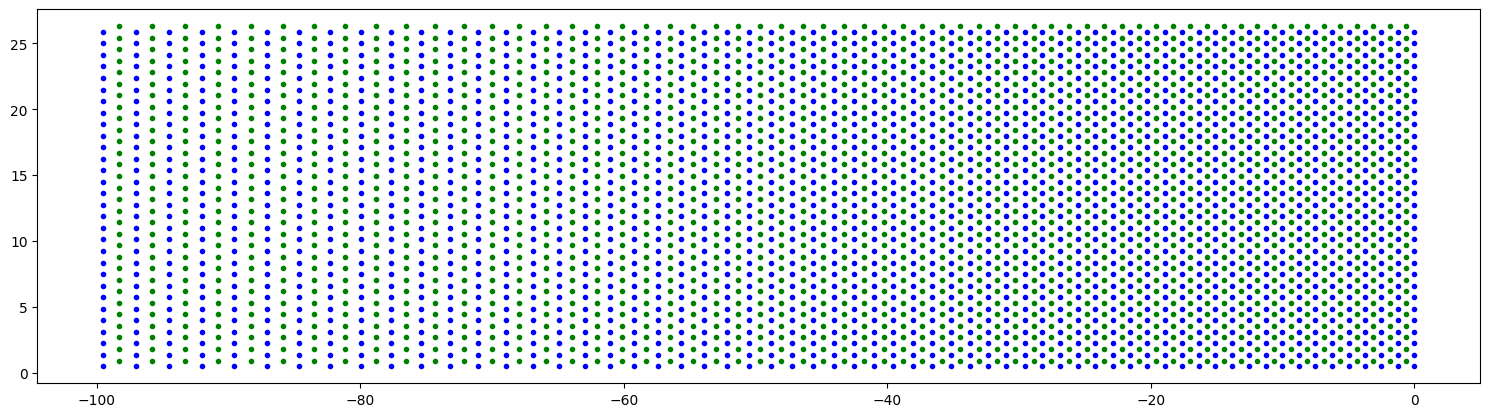

In [202]:

Y = np.arange(0, HEIGHT_MM, NOMINAL_DOTS_PER_MM*2)[:-1]
X = dotspace(0, HALF_WIDTH_MM - NOMINAL_DOTS_PER_MM)
xx, yy = np.meshgrid(X, Y)

yoffset = (Y[1] - Y[0])/2.
xoffset = (X[1] - X[0])/2
Y2 = np.arange(yoffset, HEIGHT_MM+yoffset, NOMINAL_DOTS_PER_MM*2)[:-1]
X2 = dotspace(xoffset, HALF_WIDTH_MM - NOMINAL_DOTS_PER_MM)
xx2, yy2 = np.meshgrid(X2,Y2)

# Move non-illuminated sides off the top/bottom edge.
#miny = yy[0][0]
#maxy = yy[-1][-1]
miny = min(yy[0][0], yy2[0][0])
maxy = max(yy[-1][-1], yy2[-1][-1])
deltay = HEIGHT_MM - (maxy-miny)
yy += deltay/2
yy2 += deltay/2

# TODO: we need to renormalize the output since it has been stretched beyond the width of the original img.

# Preview Plot for sanity checking:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
ax.set_aspect('equal')
#ax.plot(xx, yy, ls="None", marker=".", color="blue")
#ax.plot(xx2, yy2, ls="None", marker=".", color="green")
ax.plot(-xx, yy, ls="None", marker=".", color="blue")
ax.plot(-xx2, yy2, ls="None", marker=".", color="green")
plt.tight_layout()
plt.show()

Draw the SVG from the above parameters.

In [203]:
# Create an SVG replacing the two meshgrids from above with actual circles.
offset = (10, 10)
fill_color = 'black'
d = draw.Drawing(2*HALF_WIDTH_MM + offset[0], 
                 HEIGHT_MM + 2*offset[0],
                 origin=(-HALF_WIDTH_MM - offset[0], 0),
                 displayInline=False)
d.setPixelScale(1)
r = draw.Rectangle(-HALF_WIDTH_MM, 0, 
                   HALF_WIDTH_MM, HEIGHT_MM, 
                   rx=0.1,
                   fill='#FFFFFF', stroke='red', stroke_width="0.1")
d.append(r)
# Produce the circle pattern.
# Skip duplicate circles to avoid weird bug where LaserCAD software skips etching anything
# if there are copies at the same location.

#for xx, ys, fill_color in [[xx, yy, 'red'], [xx2, yy2, 'black'], [-xx[:,1:], yy[:,1:], 'green'], [-xx2, yy2, 'blue']]:
#for xs, ys in [[xx, yy], [xx2, yy2], [-xx[:,1:], yy[:,1:]], [-xx2, yy2]]:
#for xx, yx in [ [xx, yy], [-xx[:,1:], yy[:,1:]] ]:
#for xs, ys in [[xx, yy], [xx2, yy2], [-xx[:,1:], yy[:,1:]], [-xx2, yy2]]:
for xs, ys in [ [-xx[:,1:], yy[:,1:]], [-xx2, yy2] ]:
    for x,y in zip(xs.flatten(), ys.flatten()):
        c = draw.Circle(x, y, r=DOT_DIAMETER_MM/2., 
                        stroke_width='0.1', stroke=fill_color,
                        fill_opacity=1.0)#, id='circle')
        d.append(c)
d.saveSvg('example.svg')

In [204]:
#display(SVG(url='https://upload.wikimedia.org/wikipedia/commons/f/f6/People_%28example%29.svg'))
svg_to_fixed_width_html_image(SVG('example.svg').data.encode('ascii'), width="100%")